In [1]:
from typing import List, Callable, Tuple

import random

In [2]:
# util methods

def random_action(probability: float):
    """
    Bernoulli's distribution. 
    :param probability: True probability
    :return: True with given probability, or False otherwise
    """
    return random.random() < probability


def create_or_default(create: Callable, probability: float, default_value):
    """
    Create new value with given probability or use the default one otherwise.
    """
    return create() if random_action(probability) else default_value


def replace_values(original: List, new: List):
    """
    Replace values in a list with values from another list.
    """
    original.clear()
    for e in new:
        original.append(e)


def sort_by_values(keys: List, values: List[float]):
    """
    Sort given keys by associated values.
    """
    data = list(zip(values, keys))
    data.sort(reverse=True)
    sorted_values, sorted_keys = zip(*data)

    replace_values(keys, sorted_keys)
    replace_values(values, sorted_values)


def sort_by_value(keys: List, value_gen: Callable) -> List[float]:
    """
    Sort given keys by values generated via passed lambda and return the values.
    """
    values = list(map(value_gen, keys))
    sort_by_values(keys, values)
    return values


def remove_all(elements, elements_to_remove):
    for e in elements_to_remove:
        if e in elements:
            elements.remove(e)


In [3]:
class Param:
    """
    Single parameter of a stage.
    """
    def __init__(self, name: str, distribution: Callable):
        self.name = name
        self.distribution = distribution

    def create_value(self):
        return self.distribution()


class StageType:
    """
    Stage template that defines params for a stage.
    See create_stage generator.
    """
    def __init__(self, name, params):
        self.name = name
        self.params = params


class Stage:
    """
    Stage instance with parameter values.
    """
    def __init__(self, stage_type: StageType, values: List):
        """
        :param stage_type: back reference to the template for parameter mutation
        :param values: instance's parameter values
        """
        self.stage_type = stage_type
        self.values = values

    def __str__(self):
        return f"{self.stage_type.name}{self.values}"


def create_stage(stage_type: StageType) -> Stage:
    return Stage(stage_type, [param.create_value() for param in stage_type.params])


class Pipeline:
    """
    List of stages that can be mutated.
    """
    def __init__(self, stages: List[Stage]):
        self.stages = stages

    def __str__(self):
        return f'{" ".join(map(str, self.stages))}'

    def random_stage_index(self, with_last: bool = False):
        last = len(self.stages)
        if with_last:
            last += 1
        return random.randint(0, last - 1)

    def __lt__(self, other):
        # important for sort method usage
        return len(self.stages) < len(other.stages)


def crossover(pipeline1: Pipeline, pipeline2: Pipeline) -> List[Pipeline]:
    """
    Single-point crossover of two pipelines.
    Returns non-empty pipelines after crossover.
    """
    stages1 = pipeline1.stages
    stages2 = pipeline2.stages

    while True:
        i1 = pipeline1.random_stage_index(with_last=True)
        i2 = pipeline2.random_stage_index(with_last=True)
        if (i1 == 0 and i2 == 0) or (i1 == len(stages1) and i2 == len(stages2)):
            continue
        break

    child1 = Pipeline(stages1[:i1] + stages2[i2:])
    child2 = Pipeline(stages2[:i2] + stages1[i1:])

    return [child for child in [child1, child2] if len(child.stages) > 0]


def mutate_stage(stage: Stage, mutation_probability: float) -> Stage:
    """
    Mutate parameters of a single stage.
    :param stage: stage to mutate
    :param mutation_probability: Probability of single parameter mutation
    :return: a mutated copy of the stage
    """
    mutated_values = [create_or_default(param.create_value, mutation_probability, value) for param, value
                      in zip(stage.stage_type.params, stage.values)]
    return Stage(stage.stage_type, mutated_values)


def mutate_stages(pipeline: Pipeline, mutation_probability: float) -> Pipeline:
    """
    Mutate parameters of a single stage from the pipeline.
    :param pipeline: pipeline to mutate
    :param mutation_probability: Probability of single parameter mutation
    :return: a mutated copy of the pipeline
    """
    i = pipeline.random_stage_index()
    mutated_stage = mutate_stage(pipeline.stages[i], mutation_probability)
    return Pipeline(pipeline.stages[:i] + [mutated_stage] + pipeline.stages[i + 1:])


def remove_stage(pipeline: Pipeline):
    """
    Remove random stage from the pipeline. 
    Can be applied only to pipelines with size more than 1.
    :param pipeline: pipeline to mutate
    :return: a mutated copy of the pipeline
    """
    if len(pipeline.stages) <= 1:
        return pipeline
    deletion_index = pipeline.random_stage_index()
    return Pipeline(pipeline.stages[:deletion_index] + pipeline.stages[deletion_index + 1:])


def add_stage(pipeline: Pipeline, stage_types: List[StageType]):
    """
    Add random stage to the pipeline.
    :param pipeline: pipeline to mutate
    :param stage_types: stage types that can be used as a new stage
    :return: a mutated copy of the pipeline
    """
    stage = create_stage(random.choice(stage_types))
    insertion_index = pipeline.random_stage_index(with_last=True)
    return Pipeline(pipeline.stages[:insertion_index] + [stage] + pipeline.stages[insertion_index:])


def swap_stages(pipeline: Pipeline):
    """
    Swap to random stages in the pipeline. 
    Can be applied only to pipelines with size more than 1.
    :param pipeline: pipeline to mutate
    :return: a mutated copy of the pipeline
    """
    if len(pipeline.stages) <= 1:
        return pipeline
    i1 = pipeline.random_stage_index()
    i2 = pipeline.random_stage_index()
    while i1 == i2:
        i2 = pipeline.random_stage_index()

    stages = [stage for stage in pipeline.stages]
    stages[i1], stages[i2] = stages[i2], stages[i1]
    return Pipeline(stages)


def mutate_pipeline(pipeline: Pipeline, stage_types: List[StageType], stage_mutation_probability: float) -> Pipeline:
    """
    Apply one mutation to the pipeline.
    :param pipeline: pipeline to mutate
    :param stage_types: stage types that can be used as a new stage
    :param stage_mutation_probability: Probability of single parameter mutation
    :return: a mutated copy of the pipeline
    """
    mutations = [remove_stage,
                 lambda p: add_stage(p, stage_types),
                 swap_stages,
                 lambda p: mutate_stages(p, stage_mutation_probability)]
    mutation = random.choices(mutations, weights=[0.1, 0.1, 0.1, 0.7])[0]
    return mutation(pipeline)


def create_initial_population(stage_types: List[StageType], population_size: int,
                              pipeline_size_distribution: Callable[[], int]) -> List[Pipeline]:
    sizes = [pipeline_size_distribution() for _ in range(population_size)]
    return [Pipeline(list(map(create_stage, random.choices(stage_types, k=size)))) for size in sizes]


def tournament_selection(population: List[Pipeline], tournament_size: int) -> List[Pipeline]:
    tournament_contestants = random.sample(range(len(population)), tournament_size)
    tournament_contestants.sort()
    w1, w2 = tournament_contestants[:2]
    return [population[w1], population[w2]]


def genetic_algorithm(population: List[Pipeline],
                      generations: int,
                      stage_types: List[StageType],
                      fitness: Callable[[Pipeline], float],
                      crossover_probability: float,
                      mutation_probability: float,
                      stage_mutation_probability: float,
                      generation_callback: Callable[[List[Pipeline], List[float]], None] = None,
                      tournament_size=5) -> Tuple[List[Pipeline], List[float]]:
    population_size = len(population)
    fitness_values = sort_by_value(population, fitness)

    for generation in range(generations):
        new_population = []

        while len(new_population) < population_size:
            parent1, parent2 = tournament_selection(population, tournament_size)
            children = create_or_default(lambda: crossover(parent1, parent2), crossover_probability, [parent1, parent2])
            children = [create_or_default(lambda: mutate_pipeline(child, stage_types, stage_mutation_probability),
                                          mutation_probability,
                                          child) for child in children]
            remove_all(children, [parent1, parent2])
            new_population += children

        new_fitness_values = sort_by_value(new_population, fitness)

        population += new_population
        fitness_values += new_fitness_values

        sort_by_values(population, fitness_values)

        if generation_callback is not None:
            generation_callback(population, fitness_values)

        population = population[:population_size]
        fitness_values = fitness_values[:population_size]

    return population, fitness_values


In [4]:
import matplotlib.pyplot as plt

# Consider an example of colored chains with single size parameter
size_param = Param("size", lambda: random.randint(1, 10))


class ColorStage(StageType):
    def __init__(self, color: str):
        super().__init__(color, [size_param])


red_stage = ColorStage("red")
green_stage = ColorStage("green")
blue_stage = ColorStage("blue")
stage_types = [red_stage, green_stage, blue_stage]


def evaluate(pipeline: Pipeline) -> float:
    """
    Prioritise elements in RGB order, and de-prioritise elements that come in a different order.
    :param pipeline: pipeline to evaluate
    :return: pipeline score
    """
    res = 0
    i = 0
    n = len(pipeline.stages)
    while i < n:
        if pipeline.stages[i].stage_type.name == "red" and i < n - 2 and \
                pipeline.stages[i + 1].stage_type.name == "green" and \
                pipeline.stages[i + 2].stage_type.name == "blue":
            res += sum([sum(pipeline.stages[j].values) for j in range(i, i + 3)]) ** 2
            i += 3
        else:
            res -= sum(pipeline.stages[i].values) ** 2
            i += 1
    return res / len(pipeline.stages)


def visualize(pipelines: List[Pipeline], fitness_values: List[float]):
    max_size = 10
    pipelines = list(reversed(pipelines[:max_size]))
    fitness_values = list(reversed(fitness_values[:max_size]))

    fig, ax = plt.subplots(figsize=(10, 10))

    max_stages = 0
    for n, pipeline in enumerate(pipelines):
        max_stages = max(max_stages, len(pipeline.stages))
        for i, stage in enumerate(pipeline.stages):
            name = stage.stage_type.name
            color = "r" if name == "red" else "g" if name == "green" else "b"
            ax.scatter(i, n, color=color, edgecolors='black', s=500)
            ax.text(i, n, str(stage.values[0]), ha='center', va='center', color='w', fontweight='bold')
        ax.text(-1, n, str(round(fitness_values[n], 2)), ha='center', va='center', fontweight='bold')

    ax.set_xlim(-2, max_stages)
    ax.set_ylim(-1, len(pipelines) + 1)
    ax.axis('off')

    plt.show()


Initially colors come in random order with random values.

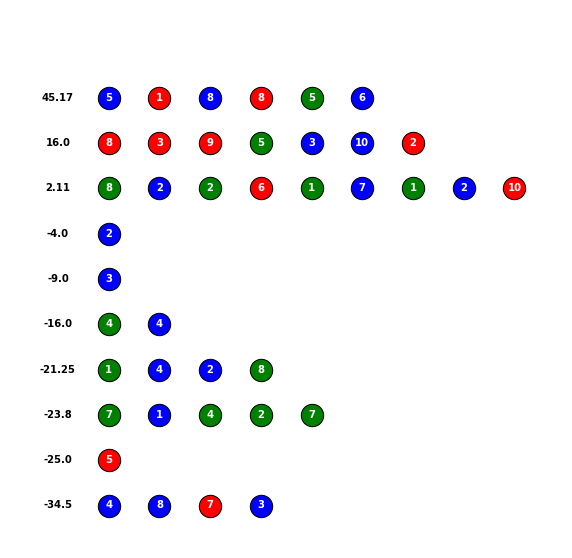

In [5]:
population = create_initial_population(stage_types, 20, lambda: random.randint(1, 10))
visualize(population, sort_by_value(population, evaluate))

After optimisation, RGB sequences with high values dominate in the population

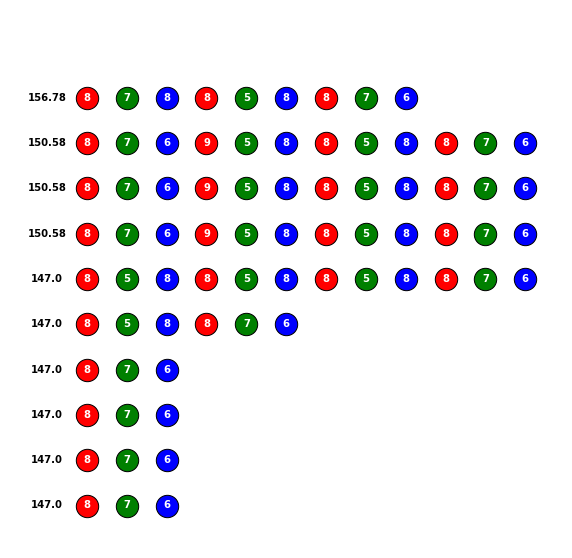

In [6]:
best_population, best_fitness_values = genetic_algorithm(population,
                                                         generations=10,
                                                         stage_types=stage_types,
                                                         fitness=evaluate,
                                                         crossover_probability=0.4,
                                                         mutation_probability=0.3,
                                                         stage_mutation_probability=0.2,
                                                         # generation_callback=visualize
                                                         )

visualize(best_population, best_fitness_values)